# The Phong model
This is an implementation of a Phong model that can render shiny surfaces, and control the shininess of the color regions.

In [ ]:
 pip install perlin-noise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing all required librabies
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise
import numpy as np
from numpy.lib.index_tricks import c_
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import requests
import torch.nn as nn
import time
from matplotlib.artist import kwdoc
import torch.nn as nn

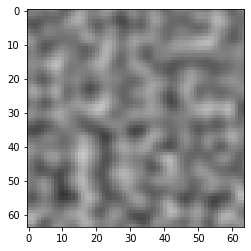

In [ ]:
# Implementing the Perlin noise function
def mk_noise(octaves,seed):
  noise = PerlinNoise(octaves=octaves, seed=seed)
  image = np.array([[noise([i/64, j/64]) for j in range(64)] for i in range(64)])
  image = image*0.5 + 0.5
  return image
 
heightfield = mk_noise(10, 11)
plt.imshow(np.concatenate([heightfield[:,:,np.newaxis],heightfield[:,:,np.newaxis],heightfield[:,:,np.newaxis]], axis = 2), cmap='gray')
plt.show()

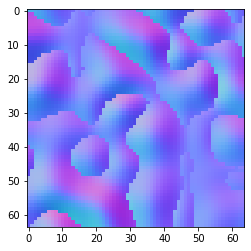

In [ ]:
# Generating a normal map as the gradient of a heightfield
# Fliping concavities (heightfield < 0.5)
def mk_normals_convex(octaves,seed,scaling):
  heightfield = mk_noise(octaves=octaves,seed=seed)
  gx, gy = np.gradient(heightfield)
  s = scaling*np.ones((64,64))
  normals = np.concatenate([gx[:,:,np.newaxis], gy[:,:,np.newaxis], s[:,:,np.newaxis]], axis = 2)
  norm = np.linalg.norm(normals, axis=2)
  normals = normals / norm[:,:,np.newaxis]
  for i in range(64):
    for j in range(64):
      if heightfield[i, j] < 0.5:
        normals[i,j,0] = - normals[i,j,0]
        normals[i,j,1] = - normals[i,j,1]
  return normals
  
normals = mk_normals_convex(4, 1, 0.05)
plt.imshow(normals*0.5 + 0.5)
plt.show()

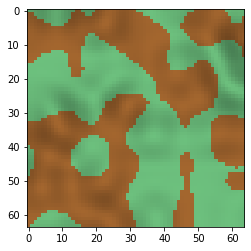

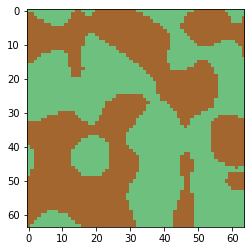

In [ ]:
# Generating a diffuse albedo map composed of regions of two random colors
def mk_diffuse_albedo(octaves,seed, normals, light):
  noise = PerlinNoise(octaves=octaves, seed=seed)
  image = np.array([[noise([i/64, j/64]) for j in range(64)] for i in range(64)])
  image = image*0.5 + 0.5

  r1 = np.random.uniform()
  g1 = np.random.uniform()
  b1 = np.random.uniform()
  r2 = np.random.uniform()
  g2 = np.random.uniform()
  b2 = np.random.uniform()

  c_r = np.ones((64,64))
  c_g = np.ones((64,64))
  c_b = np.ones((64,64))

  for i in range(64):
    for j in range(64):
      if image[i,j] < 0.5:
        c_r[i,j] = r1
        c_g[i,j] = g1
        c_b[i,j] = b1
      else:
        c_r[i,j] = r2
        c_g[i,j] = g2
        c_b[i,j] = b2

  # Calculating diffuse component of the image as: Kd * (N.L)

  diffuse_albedo = np.concatenate([c_r[:,:,np.newaxis], c_g[:,:,np.newaxis], c_b[:,:,np.newaxis]], axis=2)
  diffuse_shading = np.array([[np.max(np.dot(normals, light)[i,j], 0) for i in range(64)] for j in range(64)])
  
  diffuse = diffuse_albedo * diffuse_shading[:,:,np.newaxis]
  return diffuse, diffuse_albedo

normals = mk_normals_convex(4, 1, 0.05)
light =[0,0,1]
diffuse, diffuse_albedo = mk_diffuse_albedo(4,1,normals,light)
plt.imshow(diffuse)
plt.show()
plt.imshow(diffuse_albedo)
plt.show()

White highlights:


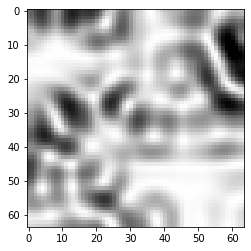

specular roughness: 1


In [53]:
# Generating a white specular albedo map 
def mk_white_specular_albedo(octaves,seed, normals, light, view):
  noise = PerlinNoise(octaves=octaves, seed=seed)
  image = np.array([[noise([i/64, j/64]) for j in range(64)] for i in range(64)])
  image = image*0.5 + 0.5
  
  # Calculating specular component of the image as: Ks * (R.V)^exp

  # Calculating R as: R = 2*(N.L)*N - L
  # R is r here
  r = (2 * np.dot(normals, light))[:,:,np.newaxis] * normals - light

  # Calculating R.V 
  t = np.array([[np.max(np.dot(r, view)[i,j], 0) for i in range(64)] for j in range(64)])

  exp = np.random.randint(1, 4)
  specular_albedo = [1,1,1]
  specular = specular_albedo * np.power(t,exp)[:,:,np.newaxis]
  roughness = np.full((64,64), exp)[:,:,np.newaxis]

  return specular, specular_albedo, roughness

normals = mk_normals_convex(4, 1, 0.05)
light = [0,0,1]
view = [0,0,1]
specular, specular_albedo, roughness = mk_white_specular_albedo(4,1,normals,light,view)
print("White highlights:")
plt.imshow(specular)
plt.show()
print("specular roughness: {}".format(roughness[0,0,0]))

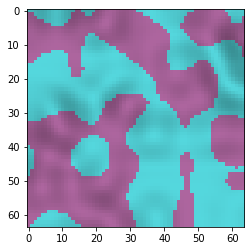

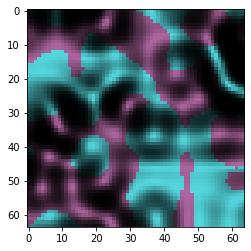

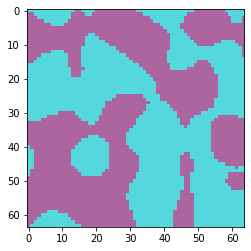

specular roughness: 3.0


In [57]:
# Generating a colored specular albedo map 
def mk_diffuse_specular(octaves,seed, normals, light, view):
  noise = PerlinNoise(octaves=octaves, seed=seed)
  image = np.array([[noise([i/64, j/64]) for j in range(64)] for i in range(64)])
  image = image*0.5 + 0.5

  exp1 = np.random.randint(1, 5)
  exp2 = np.random.randint(1, 5)
  roughness = np.zeros((64,64))

  r1 = np.random.uniform()
  g1 = np.random.uniform()
  b1 = np.random.uniform()
  r2 = np.random.uniform()
  g2 = np.random.uniform()
  b2 = np.random.uniform()

  c_r = np.ones((64,64))
  c_g = np.ones((64,64))
  c_b = np.ones((64,64))
  
  for i in range(64):
    for j in range(64):
      if image[i,j] < 0.5:
        c_r[i,j] = r1
        c_g[i,j] = g1
        c_b[i,j] = b1
        roughness[i,j] = exp1
      else:
        c_r[i,j] = r2
        c_g[i,j] = g2
        c_b[i,j] = b2
        roughness[i,j] = exp2

  albedo = np.concatenate([c_r[:,:,np.newaxis], c_g[:,:,np.newaxis], c_b[:,:,np.newaxis]], axis=2)
  diffuse_shading = np.array([[np.max(np.dot(normals, light)[i,j], 0) for i in range(64)] for j in range(64)])
  
  diffuse = albedo * diffuse_shading[:,:,np.newaxis]

  # Calculating R as: R = 2*(N.L)*N - L
  # R is r here
  r = (2 * np.dot(normals, light))[:,:,np.newaxis] * normals - light

  # Calculating R.V 
  t = np.array([[np.max(np.dot(r, view)[i,j], 0) for i in range(64)] for j in range(64)])
  #t = np.array([[np.max(np.dot(normals, light)[i,j], 0) for i in range(64)] for j in range(64)])

  specular_shading = np.power(t, roughness)
  specular = albedo * specular_shading[:,:,np.newaxis]
  roughness = roughness[:,:,np.newaxis]
  return diffuse, specular, albedo, roughness

normals = mk_normals_convex(4, 1, 0.05)
light = [0,0,1]
view = [0,0,1]
diffuse, specular, albedo, roughness = mk_diffuse_specular(4,1,normals,light,view)
plt.imshow(diffuse)
plt.show()
plt.imshow(specular)
plt.show()
plt.imshow(albedo)
plt.show()
print("specular roughness: {}".format(roughness[0,0,0]))

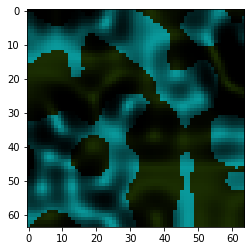

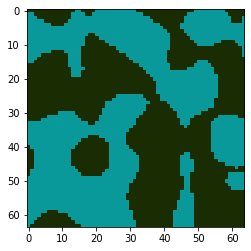

specular roughness: 4.0


In [58]:
def mk_color_specular_albedo(octaves,seed, normals, light, view):
  noise = PerlinNoise(octaves=octaves, seed=seed)
  image = np.array([[noise([i/64, j/64]) for j in range(64)] for i in range(64)])
  image = image*0.5 + 0.5

  exp1 = np.random.randint(1, 5)
  exp2 = np.random.randint(1, 5)
  roughness = np.zeros((64,64))

  r1 = np.random.uniform()
  g1 = np.random.uniform()
  b1 = np.random.uniform()
  r2 = np.random.uniform()
  g2 = np.random.uniform()
  b2 = np.random.uniform()

  c_r = np.ones((64,64))
  c_g = np.ones((64,64))
  c_b = np.ones((64,64))
  
  for i in range(64):
    for j in range(64):
      if image[i,j] < 0.5:
        c_r[i,j] = r1
        c_g[i,j] = g1
        c_b[i,j] = b1
        roughness[i,j] = exp1
      else:
        c_r[i,j] = r2
        c_g[i,j] = g2
        c_b[i,j] = b2
        roughness[i,j] = exp2
  
  # Calculating specular component of the image as: Ks * (R.V)^exp

  specular_albedo = np.concatenate([c_r[:,:,np.newaxis], c_g[:,:,np.newaxis], c_b[:,:,np.newaxis]], axis=2)

  # Calculating R as: R = 2*(N.L)*N - L
  # R is r here
  r = (2 * np.dot(normals, light))[:,:,np.newaxis] * normals - light

  # Calculating R.V 
  t = np.array([[np.max(np.dot(r, view)[i,j], 0) for i in range(64)] for j in range(64)])
  #t = np.array([[np.max(np.dot(normals, light)[i,j], 0) for i in range(64)] for j in range(64)])

  specular_shading = np.power(t, roughness)
  specular = specular_albedo * specular_shading[:,:,np.newaxis]
  roughness = roughness[:,:,np.newaxis]
  return specular, specular_albedo, roughness

normals = mk_normals_convex(4, 1, 0.05)
light = [0,0,1]
view = [0,0,1]
specular, specular_albedo, roughness = mk_color_specular_albedo(4,1,normals,light,view)
plt.imshow(specular)
plt.show()
plt.imshow(specular_albedo)
plt.show()
print("specular roughness: {}".format(roughness[0,0,0]))

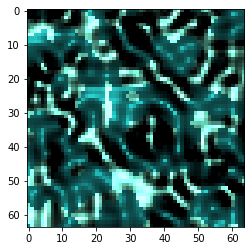

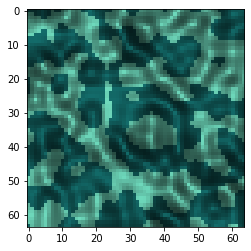

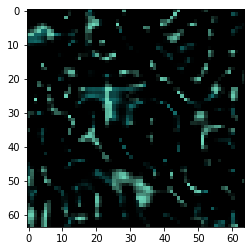

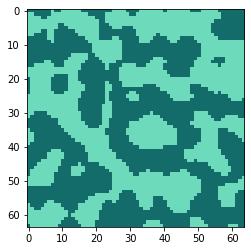

specular roughness: 3.0


In [59]:
normals = mk_normals_convex(8,1,0.03)
light = [0,0,1]
view = [0,0,1]
#diffuse, diffuse_albedo = mk_diffuse_albedo(8,1,normals,light)
diffuse, specular, albedo, roughness = mk_diffuse_specular(8,1,normals,light,view)
img = diffuse + specular
plt.imshow(img)
plt.show()
plt.imshow(diffuse)
plt.show()
plt.imshow(specular)
plt.show()
plt.imshow(albedo)
plt.show()
print("specular roughness: {}".format(roughness[0,0,0]))

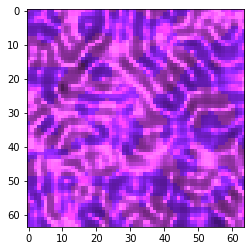

In [68]:
# Generating a random normal map, a random diffuse albedo map, and a random specular map 
# Computing the resulting image
def mk_maps():
    octaves_normals = np.random.randint(2, 20) 
    seed_normals = np.random.randint(1, 1000)
    octaves_albedo = np.random.randint(2, 20) 
    seed_albedo = np.random.randint(1, 1000)
    scaling = 0.01 + 0.1*np.random.uniform()
    light = [0,0,1]
    view = [0,0,1]
    normals = mk_normals_convex(octaves_normals, seed_normals, scaling)
    #diffuse, diffuse_albedo = mk_diffuse_albedo(octaves_albedo,seed_albedo,normals,light)
    diffuse, specular, albedo, roughness = mk_diffuse_specular(octaves_albedo,seed_albedo,normals,light,view)
    img = diffuse + specular
    return img, normals, albedo, specular, roughness

# Testing the function by displaying the image
img, n, a, s, r = mk_maps()
plt.imshow(img)
plt.show()

In [62]:
class HeightFieldDataset(Dataset):
    def __init__(self, size): 
        super().__init__()

        # Set of input images, which are composed of 3 channels of size 64x64 pixels
        self.X = np.ones((size,3,64,64), dtype=np.float32) 

        # Set of output images, which are composed of 10 channels of size 64x64 pixels
        self.Y = np.ones((size,10,64,64), dtype=np.float32)

        for i in range(size):
            img, n, a, s, r = mk_maps()
            img = img.transpose((2,0,1))
            n = n.transpose((2,0,1))
            a = a.transpose((2,0,1))
            s = s.transpose((2,0,1))
            r = r.transpose((2,0,1))
            self.X[i,:,:,:] = img
            self.Y[i,:,:,:] = np.concatenate([n,a,s,r], axis=0)

    def __getitem__(self, idx):
        return self.X[idx,:,:,:], self.Y[idx,:,:,:]

    def __len__(self):
        return len(self.X)

In [63]:
# Generating a dataset
data_size = 100
data = HeightFieldDataset(data_size)

# Spliting the dataset into a training and testing set
trainData, validData = torch.utils.data.random_split(data,(int(0.9*data_size),int(0.1*data_size)))
trainDL = DataLoader(trainData,10) # Training set contains 90% of the data arranged in batches of 10 samples
validDL = DataLoader(validData,10) # Testing set contains 10% of the data arranged in batches of 10 samples

In [ ]:
# Implementing a UNet convolutional neural network from the TP5
class UNET(nn.Module):
      def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, 16, 3, 1)

        self.refine = self.refine_block(16, out_channels, 3, 1)

      def __call__(self, x):

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        refine = self.refine(upconv1)

        return refine

      def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )

        return contract

      def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
            )
        
        return expand
      
      def refine_block(self, in_channels, out_channels, kernel_size, padding):
        refine = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding)
            )                          

        return refine

In [ ]:
# Implementing a UNet convolutional neural network similar to the one from the paper
class UNET1(nn.Module):
      def __init__(self, in_channels, out_channels):
        super().__init__()

        # Encoder
        self.conv1 = self.contract_block(in_channels, 128, 3, 1)
        self.conv2 = self.contract_block(128, 256, 3, 1)
        self.conv3 = self.contract_block(256, 512, 3, 1)
        self.conv4 = self.contract_block(512, 512, 3, 1)

        # Decoder
        self.upconv4 = self.expand_block(512, 512, 3, 1)
        self.upconv3 = self.expand_block(512, 256, 3, 1)
        self.upconv2 = self.expand_block(256*2, 128, 3, 1)
        self.upconv1 = self.expand_block(128*2, 64, 3, 1)

        self.refine = self.refine_block(64, out_channels, 3, 1)

      def __call__(self, x):

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        
        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        refine = self.refine(upconv1)

        return refine

      def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
            )

        return contract

      def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1) 
            )
        
        return expand
      
      def refine_block(self, in_channels, out_channels, kernel_size, padding):
        refine = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding)
            )                          

        return refine

In [ ]:
# Creating the training function
def train(model, train_dl, valid_dl, loss_fn, optimizer, epochs=1):
    start = time.time()
    model.cuda() 

    for epoch in range(epochs):

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  
                dataloader = train_dl
            else:
                model.train(False)  
                dataloader = valid_dl

            running_loss = 0.0

            step = 0

            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y)

                running_loss += loss*dataloader.batch_size 

            epoch_loss = running_loss / len(dataloader.dataset)

            if epoch % 100 == 0:
                print('{} Loss: {:.4f} '.format(phase, epoch_loss))

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 

In [64]:
# Training the network with a L1 loss and Adam optimizer, for 500 epochs with a learning rate of 0.001

materialNetL1 = UNET(3,10)
loss_func = nn.L1Loss()
optimizer = torch.optim.Adam(materialNetL1.parameters(), lr=0.001)
train(materialNetL1, trainDL, validDL, loss_func, optimizer, epochs=1000)

train Loss: 0.5733 
valid Loss: 0.5904 
train Loss: 0.2142 
valid Loss: 0.3073 
train Loss: 0.1928 
valid Loss: 0.2998 
train Loss: 0.1806 
valid Loss: 0.2888 
train Loss: 0.1732 
valid Loss: 0.2960 
train Loss: 0.1700 
valid Loss: 0.2970 
train Loss: 0.1655 
valid Loss: 0.2951 
train Loss: 0.1640 
valid Loss: 0.2976 
train Loss: 0.1603 
valid Loss: 0.2900 
train Loss: 0.1590 
valid Loss: 0.2934 
Training complete in 2m 22s


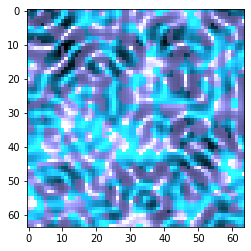

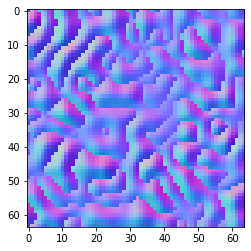

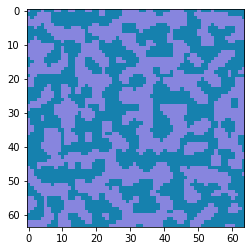

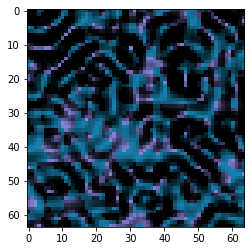

specular roughness: 4.0


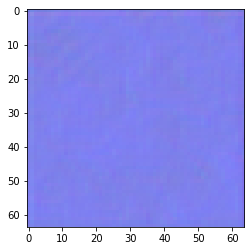

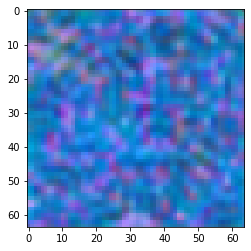

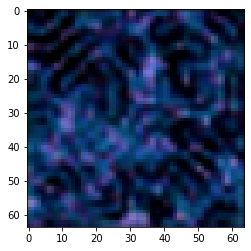

specular roughness: 3.4328696727752686


In [72]:
# Testing the trained network on a triplet from the test set
xb, yb = next(iter(validDL))
# Each batch has 10 triplets, so you can vary the index from 0 to 9 to test on different inputs
idx = 4

# Showing input
input = xb.detach().numpy()
img = input[idx,:,:,:]
img = img.transpose((1,2,0))
plt.imshow(img)
plt.show()

# Showing ground truth
GT = yb.detach().numpy()
nGT = GT[idx,0:3,:,:]
nGT = nGT.transpose((1,2,0))
plt.imshow(nGT*0.5+0.5)
plt.show()
dGT = GT[idx,3:6,:,:]
dGT = dGT.transpose((1,2,0))
plt.imshow(dGT)
plt.show()
sGT = GT[idx,6:9,:,:]
sGT = sGT.transpose((1,2,0))
plt.imshow(sGT)
plt.show()
rGT = GT[idx,9,:,:]
print("specular roughness: {}".format(np.mean(rGT[0,0])))

# Showing prediction
xb = xb.cuda() 
pred = materialNetL1(xb)
pred = pred.cpu() 
pred = pred.detach().numpy()
nPred = pred[idx,0:3,:,:]
nPred = nPred.transpose((1,2,0))
plt.imshow(nPred*0.5+0.5)
plt.show()
dPred = pred[idx,3:6,:,:]
dPred = dPred.transpose((1,2,0))
plt.imshow(dPred)
plt.show()
sPred = pred[idx,6:9,:,:]
sPred = sPred.transpose((1,2,0))
plt.imshow(sPred)
plt.show()
rPred = pred[idx,9,:,:]
print("specular roughness: {}".format(np.mean(rPred)))

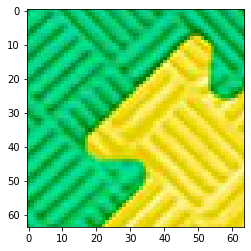

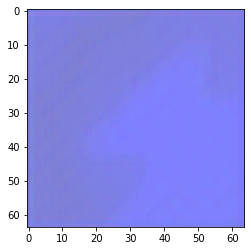

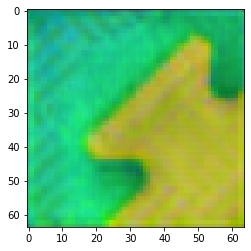

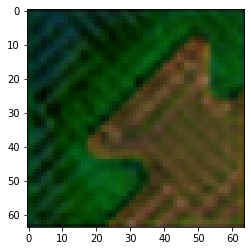

specular roughness: 1.8825538158416748


In [83]:
# Testing the network on real images
# Get an image from an URL, you can test different images from img00.png to img09.png

#url = "https://github.com/valentin-deschaintre/Single-Image-SVBRDF-Capture-rendering-loss/blob/master/inputExamples/IMG_20180104_230238.png"
url = "http://www-sop.inria.fr/members/Adrien.Bousseau/teaching/dataset_realworld/64/img00.png"
img = np.array(Image.open(requests.get(url, stream=True).raw))/255.
plt.imshow(img)
plt.show()

img = img.transpose((2,0,1)) 
imgBatch = np.ones((1,3,64,64), dtype=np.float32)
imgBatch[0,:,:,:] = img[:,:,:]
imgBatch = torch.from_numpy(imgBatch)
img = imgBatch.cuda()

# Calling the UNet on the image and displaying the result
pred = materialNetL1(img)
pred = pred.cpu() 
pred = pred.detach().numpy()
nPred = pred[0,0:3,:,:]
nPred = nPred.transpose((1,2,0))
plt.imshow(nPred*0.5+0.5)
plt.show()
dPred = pred[0,3:6,:,:]
dPred = dPred.transpose((1,2,0))
plt.imshow(dPred)
plt.show()
sPred = pred[0,6:9,:,:]
sPred = sPred.transpose((1,2,0))
plt.imshow(sPred)
plt.show()
rPred = pred[0,9,:,:]
print("specular roughness: {}".format(np.mean(rPred)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


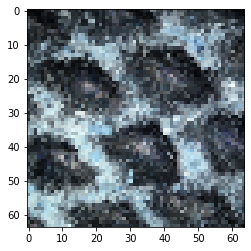

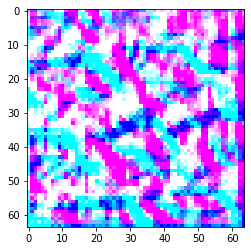

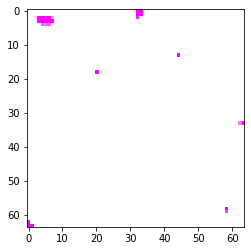

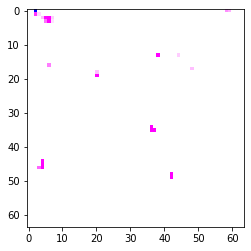

specular roughness: 41.25567626953125


In [85]:
# Testing the network on real images
# Get an image from an URL, you can test different images from img00.png to img09.png

import cv2 as cv
from PIL import Image
img = cv.imread('/content/drive/MyDrive/project/IMG_6950.png')
img = cv.resize(img, (64,64), interpolation= cv.INTER_LINEAR)
plt.imshow(img)
plt.show()

img = img.transpose((2,0,1)) 
imgBatch = np.ones((1,3,64,64), dtype=np.float32)
imgBatch[0,:,:,:] = img[:,:,:]
imgBatch = torch.from_numpy(imgBatch)
img = imgBatch.cuda()

# Calling the UNet on the image and displaying the result
pred = materialNetL1(img)
pred = pred.cpu() 
pred = pred.detach().numpy()
nPred = pred[0,0:3,:,:]
nPred = nPred.transpose((1,2,0))
plt.imshow(nPred*0.5+0.5)
plt.show()
dPred = pred[0,3:6,:,:]
dPred = dPred.transpose((1,2,0))
plt.imshow(dPred)
plt.show()
sPred = pred[0,6:9,:,:]
sPred = sPred.transpose((1,2,0))
plt.imshow(sPred)
plt.show()
rPred = pred[0,9,:,:]
print("specular roughness: {}".format(np.mean(rPred)))

# **Possible extensions**

We encourage you to explore several extensions for this practical exercise:

**More complex material model:** 

Implement a Phong model to render shiny surfaces, and control the shininess of the color regions with an additional map. Once this more complex data is in place, you can modify the UNet to also predict the per-pixel shininess. Test this model on synthetic and real images of shiny surfaces. See [1] for additional ideas around this topic.

**Procedural material representation:** 

The training images were generated using a *procedural texturing* model, which is capable of producing diverse surfaces by varying a few *parameters* such as the Perlin noise frequency, the normal map scaling, and the two albedo map colors. While the UNet model predicts the final diffuse color and normal vector at each pixel, an alternative approach is to predict the parameters of the procedural model. 

To do so, implement a neural network that takes an image as input and predicts a vector of parameters [diffuse color 1, diffuse color 2, diffuse color frequency, normal map frequency, normal map scaling factor]. Feeding these parameters to the procedural texturing model should produce albedo and normal maps that resemble the input. You can build the network around a classification architecture such as AlexNET, that applies several convolutional layers to reduce the image resolution and increase the feature depth, and then reshape this latent representation into a vector that goes trough a few fully-connected layers to produce the output. While you can use a standard L1 loss to measure the quality of the prediction against the ground truth parameters, care should be taken to compare the two predicted albedo colors to each of the ground truth albedo colors, since their ordering is aribtrary. See [2] for additional ideas around this topic.

**References**

[1]  Single-Image SVBRDF Capture with a Rendering-Aware Deep Network

Valentin Deschaintre, Miika Aittala, Fr√©do Durand, George Drettakis, Adrien Bousseau 

SIGGRAPH 2018

http://www-sop.inria.fr/reves/Basilic/2018/DADDB18/

[2] A Novel Framework For Inverse Procedural Texture Modeling

Yiwei Hu, Julie Dorsey, Holly Rushmeier

SIGGRAPH Asia 2019

https://graphics.cs.yale.edu/publications/novel-framework-inverse-procedural-texture-modeling


